# 3D displacement from asc/desc InSAR & azimuth offset

Need the results from:
1. [offset_postproc.ipynb](./offset_postproc.ipynb)
2. [ifgram_postproc.ipynb](./ifgram_postproc.ipynb)

In [2]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from scipy import linalg
from skimage.transform import resize
from mintpy.utils import ptime, readfile, writefile, plot as pp, utils as ut
from mintpy.asc_desc2horz_vert import get_design_matrix4east_north_up
from mintpy.ifgram_inversion import skip_invalid_obs
from mintpy.cli import view, image_stitch
plt.rcParams.update({'font.size': 12})

S, N, W, E = 35.3, 39.0, 35.0, 39.5   # same as Fig. 1
ref_lat, ref_lon = 36.3, 38.3  # 36.3, 38.5

proj_dir = os.path.expanduser('~/data/archives/2023TurkeyEQ')
work_dir = os.path.join(proj_dir, 'data')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# output
enu_file = os.path.join(work_dir, 'dis_enu.h5')
enu_std_file = os.path.join(work_dir, 'dis_enu_std.h5')

Go to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/data


## 1. Stitich adjcent tracks

files to be stitched: ['S1_A116_20230204_20230228/offRg_ERA5_SET.geo', 'S1_A014_20230128_20230209/offRg_ERA5_SET.geo']
datasets to be stitched: [None]
##################################################
read displacement from file: S1_A116_20230204_20230228/offRg_ERA5_SET.geo
------------------------------
read data from file: S1_A014_20230128_20230209/offRg_ERA5_SET.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
average offset between two matrices in the common area: 0.2938580244868601
offset all pixel values in the 2nd matrix by 0.2938580244868601 
create output metadata and matrix in shape of (1332, 1620)
plot stitching & shifting result ...
figure size : [12.77, 8.40]
save figure to file: S1_ASC/offRg_ERA5_SET_01.png
##################################################
write file: S1_ASC/offRg_ERA5_SET.geo
write file: S1_ASC/offRg_ERA5_SET.geo.rsc
showing ...


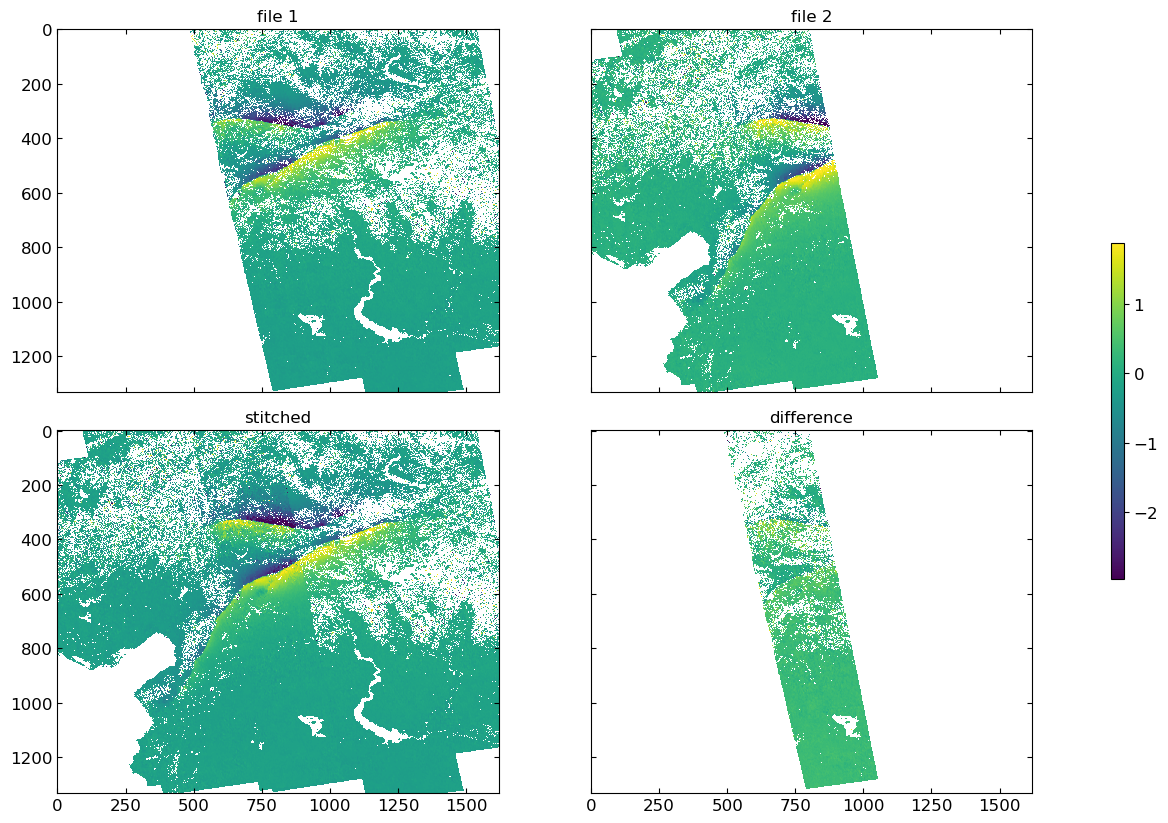

files to be stitched: ['S1_A116_20230204_20230228/offRgStd.geo', 'S1_A014_20230128_20230209/offRgStd.geo']
datasets to be stitched: [None]
##################################################
read filt_dense_offsets from file: S1_A116_20230204_20230228/offRgStd.geo
------------------------------
read data from file: S1_A014_20230128_20230209/offRgStd.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
average offset between two matrices in the common area: 0.016427411000260166
offset all pixel values in the 2nd matrix by 0.016427411000260166 
create output metadata and matrix in shape of (1332, 1620)
plot stitching & shifting result ...
figure size : [12.77, 8.40]
save figure to file: S1_ASC/offRgStd_01.png
##################################################
write file: S1_ASC/offRgStd.geo
write file: S1_ASC/offRgStd.geo.rsc
showing ...


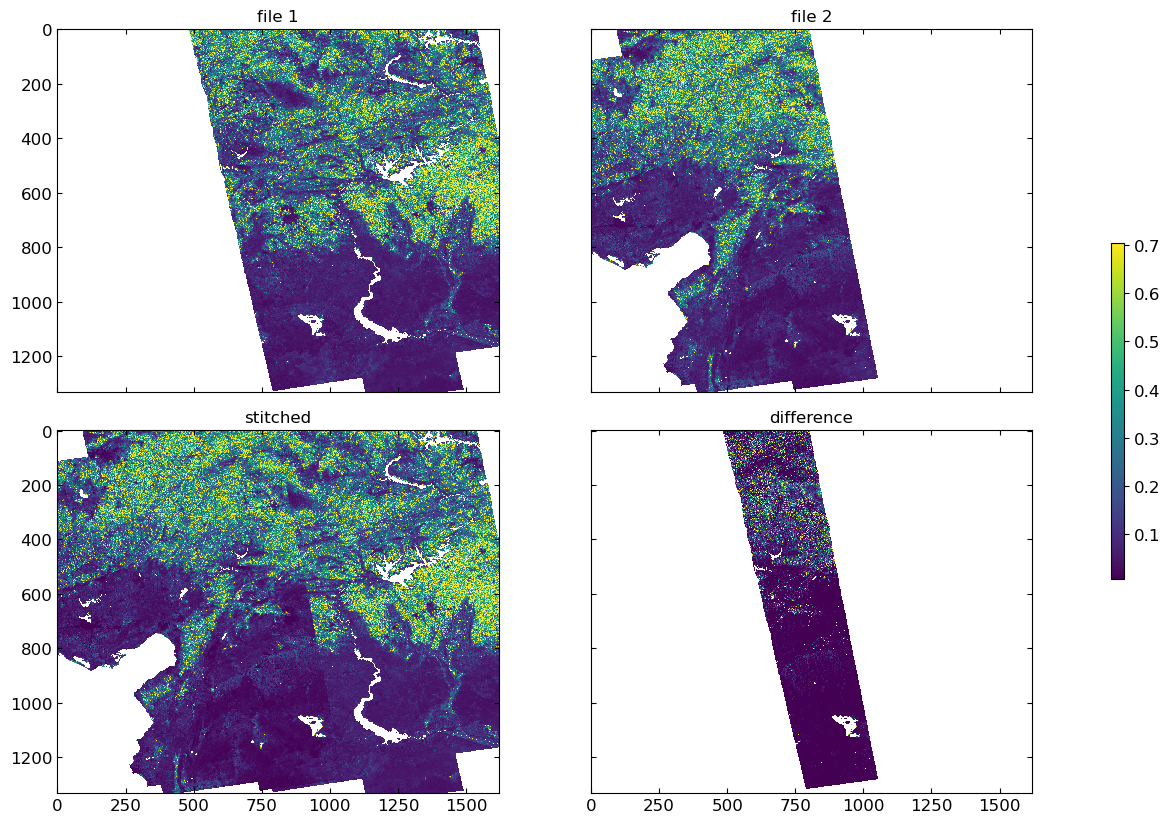

files to be stitched: ['S1_A116_20230204_20230228/offAz.geo', 'S1_A014_20230128_20230209/offAz.geo']
datasets to be stitched: [None]
##################################################
read filt_dense_offsets from file: S1_A116_20230204_20230228/offAz.geo
------------------------------
read data from file: S1_A014_20230128_20230209/offAz.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
average offset between two matrices in the common area: -0.06070100046171957
offset all pixel values in the 2nd matrix by -0.06070100046171957 
create output metadata and matrix in shape of (1332, 1620)
plot stitching & shifting result ...
figure size : [12.77, 8.40]
save figure to file: S1_ASC/offAz_01.png
##################################################
write file: S1_ASC/offAz.geo
write file: S1_ASC/offAz.geo.rsc
showing ...


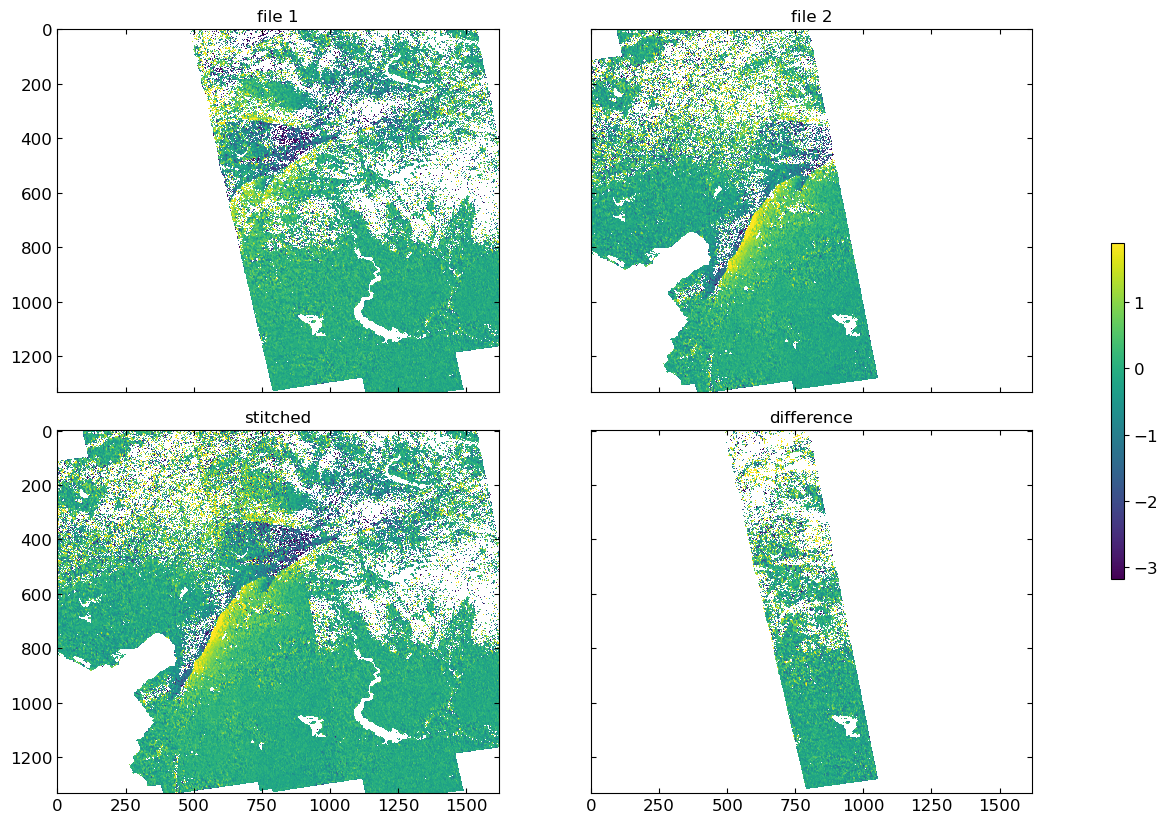

files to be stitched: ['S1_A116_20230204_20230228/offAzStd.geo', 'S1_A014_20230128_20230209/offAzStd.geo']
datasets to be stitched: [None]
##################################################
read filt_dense_offsets from file: S1_A116_20230204_20230228/offAzStd.geo
------------------------------
read data from file: S1_A014_20230128_20230209/offAzStd.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
average offset between two matrices in the common area: -0.022288594715511652
offset all pixel values in the 2nd matrix by -0.022288594715511652 
create output metadata and matrix in shape of (1332, 1620)
plot stitching & shifting result ...
figure size : [12.77, 8.40]
save figure to file: S1_ASC/offAzStd_01.png
##################################################
write file: S1_ASC/offAzStd.geo
write file: S1_ASC/offAzStd.geo.rsc
showing ...


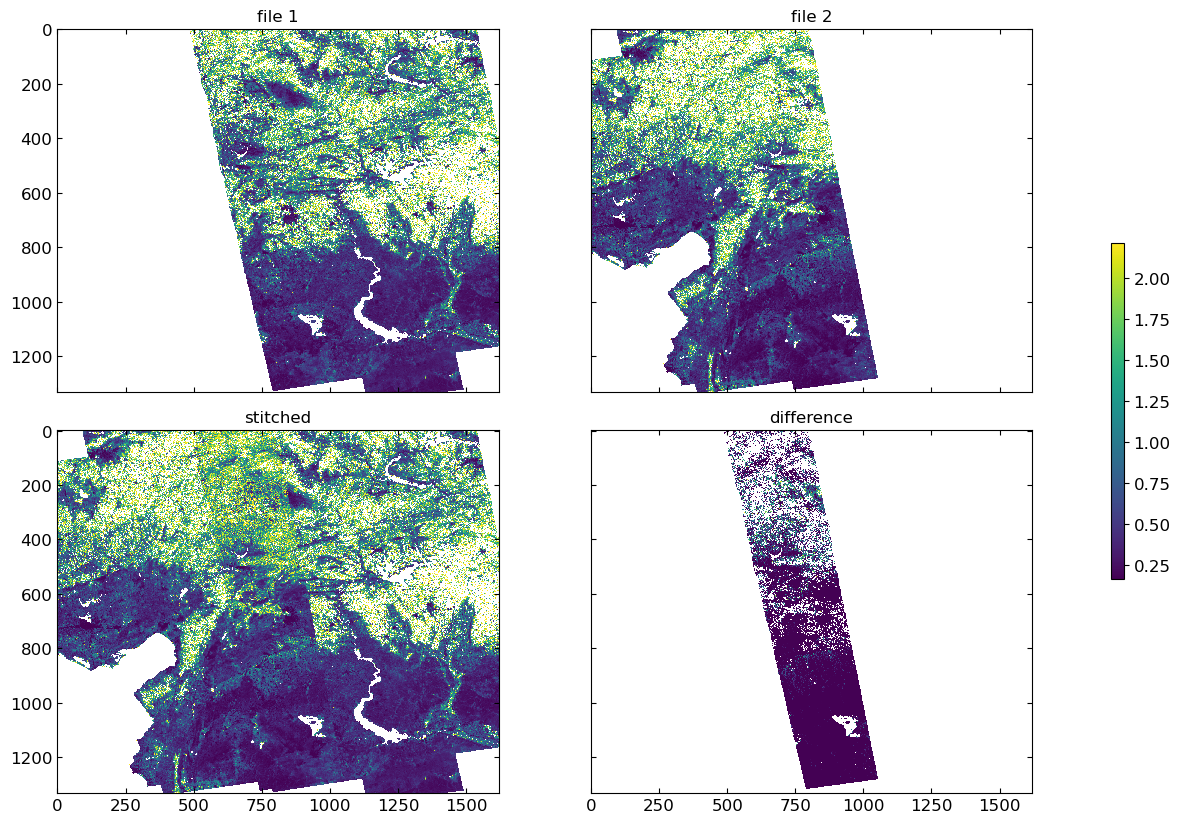

files to be stitched: ['S1_A116_20230204_20230228/los.geo', 'S1_A014_20230128_20230209/los.geo']
datasets to be stitched: [None]
##################################################
read los from file: S1_A116_20230204_20230228/los.geo
------------------------------
read data from file: S1_A014_20230128_20230209/los.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
create output metadata and matrix in shape of (1332, 1620)
##################################################
write file: S1_ASC/los.geo
write file: S1_ASC/los.geo.rsc
showing ...


In [50]:
dnames = ['S1_A116_20230204_20230228', 'S1_A014_20230128_20230209']
fbases = ['offRg_ERA5_SET.geo', 'offRgStd.geo', 'offAz.geo', 'offAzStd.geo', 'los.geo']
opts = ['', '', '', '', '--no-offset']
for fbase, opt in zip(fbases, opts):
    image_stitch.main(f'{dnames[0]}/{fbase} {dnames[1]}/{fbase} -o S1_ASC/{fbase} {opt}'.split())

## 2. Read (and resize) displacement and geometry

In [57]:
# inputs
# ALL files MUST be geocoded into the same bounding box (SNWE)
# The 1st file is used as the grid size reference for the output
fnames = [
    os.path.join(work_dir, 'S1_ASC/offRg_ERA5_SET.geo'),
    os.path.join(work_dir, 'S1_ASC/OffAz.geo'),
    os.path.join(work_dir, 'S1_D021_20230129_20230210/offRg_ERA5_SET.geo'),
    os.path.join(work_dir, 'S1_D021_20230129_20230210/OffAz.geo'),
    os.path.join(work_dir, 'ALOS2_A184_20220905_20230220/geo_filt_msk_ERA5_SET.unw'),
    os.path.join(work_dir, 'ALOS2_D077_20220916_20230217/geo_filt_msk_ERA5_SET.unw'),
]
fstd_names = [
    os.path.join(work_dir, 'S1_ASC/offRgStd.geo'),
    os.path.join(work_dir, 'S1_ASC/offAzStd.geo'),
    os.path.join(work_dir, 'S1_D021_20230129_20230210/offRgStd.geo'),
    os.path.join(work_dir, 'S1_D021_20230129_20230210/offAzStd.geo'),
    0.05,
    0.05,
]
num_file = len(fnames)
obs_direction = np.array(['range', 'azimuth', 'range', 'azimuth', 'range', 'range'])

In [73]:
atr = readfile.read_attribute(fnames[0])
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
# calculate reference point in y/x

dis_list, dis_std_list, inc_angle_list, az_angle_list = [], [], [], []
for i, fname in enumerate(fnames):
    # read displacement
    print(f'read data from file {i+1}: {fname}')
    dis, atr_i = readfile.read(fname)
    # convert phase to range
    if fname.endswith('.unw'):
        dis *= float(atr_i['WAVELENGTH']) / (4.0 * np.pi)
    # make positive range change for motion towards the satellite
    # to be consistent with the design matrix convention from mintpy.asc_desc2horz_vert.py
    if obs_direction[i] == 'range':
        dis *= -1

    # read displacement std
    fstd_name = fstd_names[i]
    if isinstance(fstd_name, str):
        dis_std = readfile.read(fstd_name)[0]
    else:
        dis_std = np.ones(dis.shape, dtype=np.float32) * fstd_name

    # read geometry
    los_file = os.path.join(os.path.dirname(fname), 'los.geo')
    inc_angle = readfile.read(los_file, datasetName='incidenceAngle')[0];  inc_angle[inc_angle == 0] = np.nan
    az_angle  = readfile.read(los_file, datasetName='azimuthAngle')[0];    az_angle[az_angle == 0] = np.nan

    # spatial referencing
    coord = ut.coordinate(atr_i)
    ref_y, ref_x = coord.geo2radar(ref_lat, ref_lon)[:2]
    print(f'\tspatial referencing to (lat, lon) = ({ref_lat}, {ref_lon}), (y, x) = ({ref_y}, {ref_x})')
    if np.isnan(dis[ref_y, ref_x]):
        raise ValueError('reference point is in masked out region! Choose a different one!')
    dis -= dis[ref_y, ref_x]

    # resize
    if dis.shape != (length, width):
        print(f'\tresizing shape from {dis.shape} to {(length,width)}')
        kwargs = dict(output_shape=(length, width), order=0, mode='constant', anti_aliasing=False, preserve_range=True)
        #kwargs = dict(output_shape=(length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)
        dis       = resize(np.array(dis),       **kwargs)
        dis_std   = resize(np.array(dis_std),   **kwargs)
        inc_angle = resize(np.array(inc_angle), **kwargs)
        az_angle  = resize(np.array(az_angle),  **kwargs)

    dis_list.append(dis)
    dis_std_list.append(dis_std)
    inc_angle_list.append(inc_angle)
    az_angle_list.append(az_angle)

dis_mat = np.array(dis_list, dtype=np.float32)
dis_std_mat = np.array(dis_std_list, dtype=np.float32)
inc_angle_mat = np.array(inc_angle_list, dtype=np.float32)
az_angle_mat = np.array(az_angle_list, dtype=np.float32)
del dis_list, dis_std_list, inc_angle_list, az_angle_list
print('finished reading data.')

read data from file 1: /Users/yunjunz/data/archives/2023TurkeyEQ/data/S1_ASC/offRg_ERA5_SET.geo
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (972, 1188)
read data from file 2: /Users/yunjunz/data/archives/2023TurkeyEQ/data/S1_ASC/OffAz.geo
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (972, 1188)
read data from file 3: /Users/yunjunz/data/archives/2023TurkeyEQ/data/S1_D021_20230129_20230210/offRg_ERA5_SET.geo
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (972, 1188)
read data from file 4: /Users/yunjunz/data/archives/2023TurkeyEQ/data/S1_D021_20230129_20230210/OffAz.geo
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (972, 1188)
read data from file 5: /Users/yunjunz/data/archives/2023TurkeyEQ/data/ALOS2_A184_20220905_20230220/geo_filt_msk_ERA5_SET.unw
	spatial referencing to (lat, lon) = (36.3, 38.3), (y, x) = (3240, 3960)
	resizing shape from (4440, 5400) to (1332, 1620)
read data from file 6: /Users/yunjunz/data/archives/2023Turk

save figure to file /Users/yunjunz/data/archives/2023TurkeyEQ/notebooks/docs/dis_obs.png


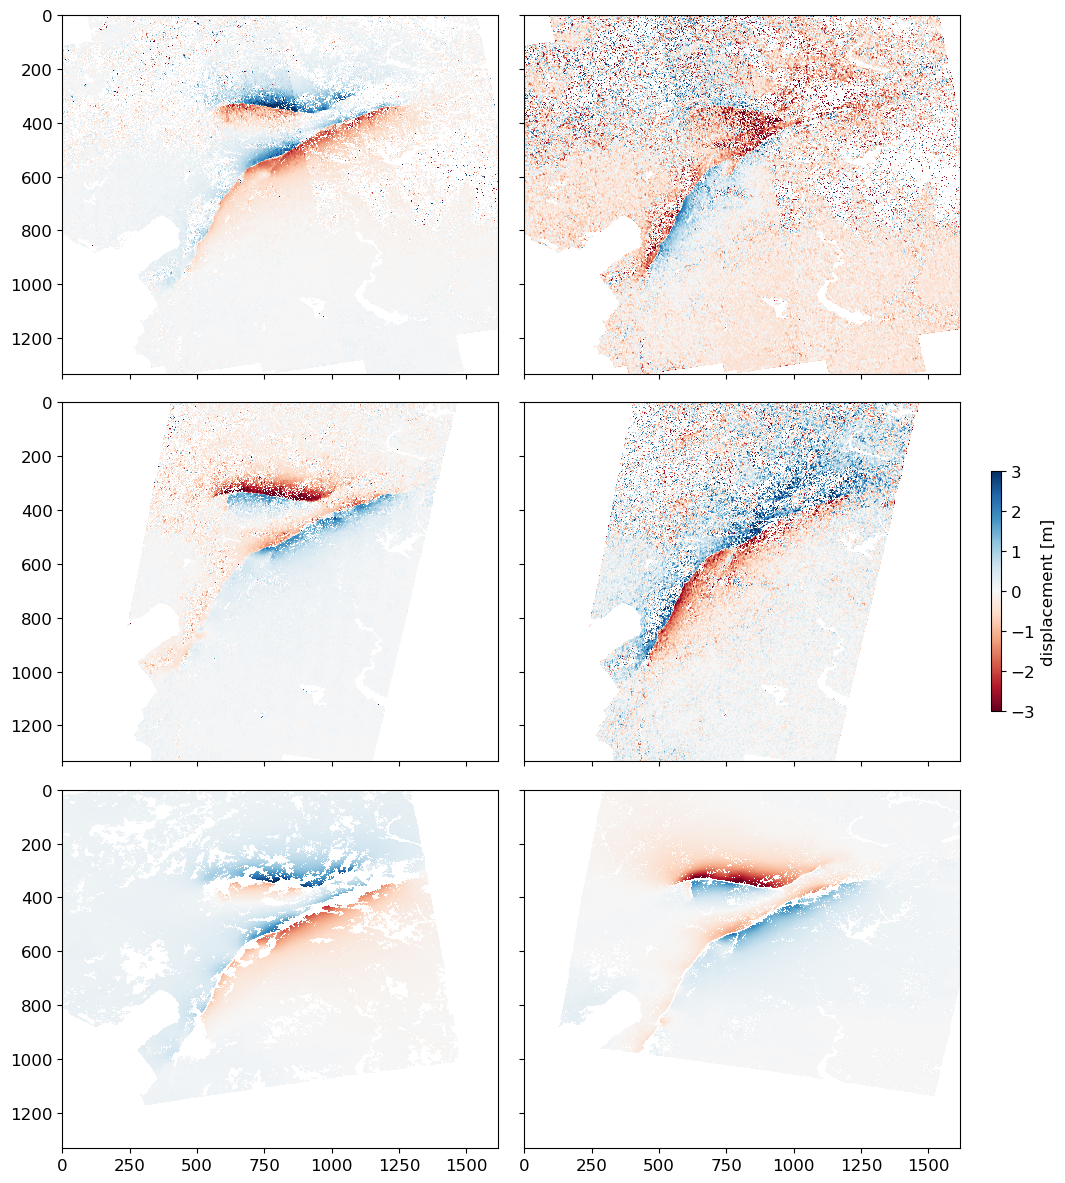

In [74]:
# plot
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=[10, 12], sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    im = ax.imshow(dis_mat[i,:], vmin=-3, vmax=3, cmap='RdBu', interpolation='nearest')
    #im = ax.imshow(dis_std_mat[i,:], vmin=0, vmax=1.0, cmap='RdBu_r', interpolation='nearest')
fig.tight_layout()

# axis format
cax = fig.add_axes([1.0, 0.4, 0.01, 0.2])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('displacement [m]')

out_fig = os.path.join(proj_dir, f'notebooks/docs/dis_obs.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## 3. Estimate 3D displacement field

In [75]:
# calculate the weight matrix
apply_weight = False

# pixel-wise inversion with invalid pixels skipped.
dis_enu = np.zeros((3, length, width), dtype=np.float32) * np.nan
dis_enu_std = np.zeros((3, length, width), dtype=np.float32) * np.nan
num_pix = length * width
prog_bar = ptime.progressBar(maxValue=num_pix)
for i in range(num_pix):
    prog_bar.update(i+1, every=1000, suffix=f'{i+1} / {num_pix}')
    y, x = i // width, i % width

    los_inc_angle = inc_angle_mat[:, y, x]
    los_az_angle = az_angle_mat[:, y, x]
    dis_los = dis_mat[:, y, x].reshape(-1, 1)
    dis_los_std = dis_std_mat[:, y, x].reshape(-1, 1)
    if np.all(np.isnan(los_inc_angle)):
        continue

    # construct design matrix
    G = get_design_matrix4east_north_up(los_inc_angle, los_az_angle, obs_direction)
    dis_los, [G, dis_los_std] = skip_invalid_obs(dis_los, mat_list=[G, dis_los_std])

    # invert
    if apply_weight:
        w_sqrt = 1. / dis_los_std
        X, e2 = linalg.lstsq(np.multiply(G, w_sqrt), np.multiply(dis_los, w_sqrt), cond=1e-5)[:2]
    else:
        X, e2 = linalg.lstsq(G, dis_los, cond=1e-5)[:2]

    if e2.size != 0:
        dis_enu[:, y, x] = X.flatten()

        # calculate inversion quality
        #dis_std[y, x] = np.sqrt(e2)
        Gplus = linalg.pinv(G)
        dis_los_cov = np.diag(np.square(dis_los_std.flatten()))
        dis_enu_cov = np.linalg.multi_dot([Gplus, dis_los_cov, Gplus.T])
        dis_enu_std[:, y, x] = np.sqrt(np.diag(dis_enu_cov))
prog_bar.close()

[==================================================] 2157840 / 2157840  216s /     4s 


### a. Write result to HDF5 file

In [76]:
# write to HDF5 file
for data, fname in zip([dis_enu, dis_enu_std], [enu_file, enu_std_file]):
    ds_dict = {
        'east'  : data[0].reshape(length, width),
        'north' : data[1].reshape(length, width),
        'up'    : data[2].reshape(length, width),
    }
    atr['FILE_TYPE'] = 'displacement'
    atr['DATA_TYPE'] = 'float32'
    atr['UNIT'] = 'm'
    atr['BANDS'] = len(ds_dict.keys())
    atr['REF_LAT'], atr['REF_LON'] = ref_lat, ref_lon
    #ref_y, ref_x = coord = ut.coordinate(atr).geo2radar(ref_lat, ref_lon)[:2]
    atr['REF_Y'], atr['REF_X'] = coord = ut.coordinate(atr).geo2radar(ref_lat, ref_lon)[:2]
    writefile.write(ds_dict, fname, metadata=atr)

create HDF5 file: /Users/yunjunz/data/archives/2023TurkeyEQ/data/dis_enu.h5 with w mode
create dataset /east  of float32    in size of (1332, 1620)         with compression=None
create dataset /north of float32    in size of (1332, 1620)         with compression=None
create dataset /up    of float32    in size of (1332, 1620)         with compression=None
finished writing to /Users/yunjunz/data/archives/2023TurkeyEQ/data/dis_enu.h5
create HDF5 file: /Users/yunjunz/data/archives/2023TurkeyEQ/data/dis_enu_std.h5 with w mode
create dataset /east  of float32    in size of (1332, 1620)         with compression=None
create dataset /north of float32    in size of (1332, 1620)         with compression=None
create dataset /up    of float32    in size of (1332, 1620)         with compression=None
finished writing to /Users/yunjunz/data/archives/2023TurkeyEQ/data/dis_enu_std.h5


### b. Quality check

save figure to file /Users/yunjunz/data/archives/2023TurkeyEQ/notebooks/docs/dis_enu.png


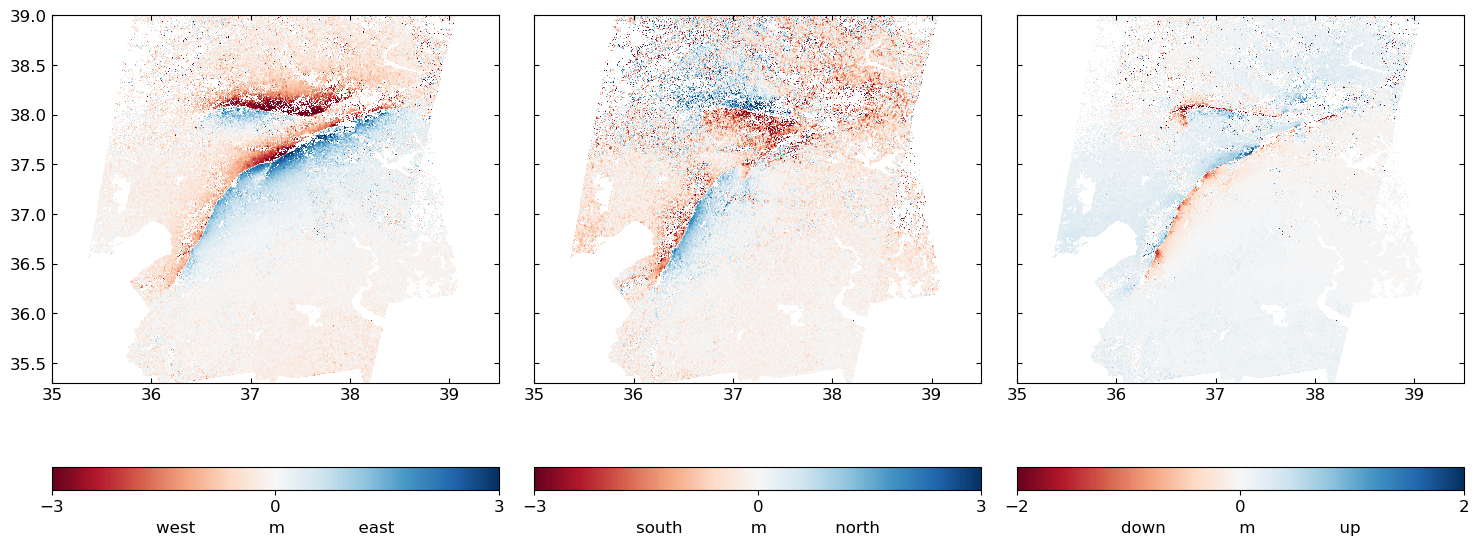

In [77]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharex=True, sharey=True)
kwargs = dict(extent=(W, E, S, N), cmap='RdBu', interpolation='nearest')
vlims = [3, 3, 2]
im1 = axs[0].imshow(dis_enu[0,:].reshape(length, width), vmin=-vlims[0], vmax=vlims[0], **kwargs)
im2 = axs[1].imshow(dis_enu[1,:].reshape(length, width), vmin=-vlims[1], vmax=vlims[1], **kwargs)
im3 = axs[2].imshow(dis_enu[2,:].reshape(length, width), vmin=-vlims[2], vmax=vlims[2], **kwargs)
ims = [im1, im2, im3]
labels = ['west              m              east',
          'south             m             north',
          'down              m                up']
for i, (ax, im, label, vlim) in enumerate(zip(axs, ims, labels, vlims)):
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=[-vlim, 0, vlim])
    cbar.set_label(label)
fig.tight_layout()
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

# output
out_fig = os.path.join(proj_dir, f'notebooks/docs/dis_enu.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /Users/yunjunz/data/archives/2023TurkeyEQ/notebooks/docs/dis_enu_std.png


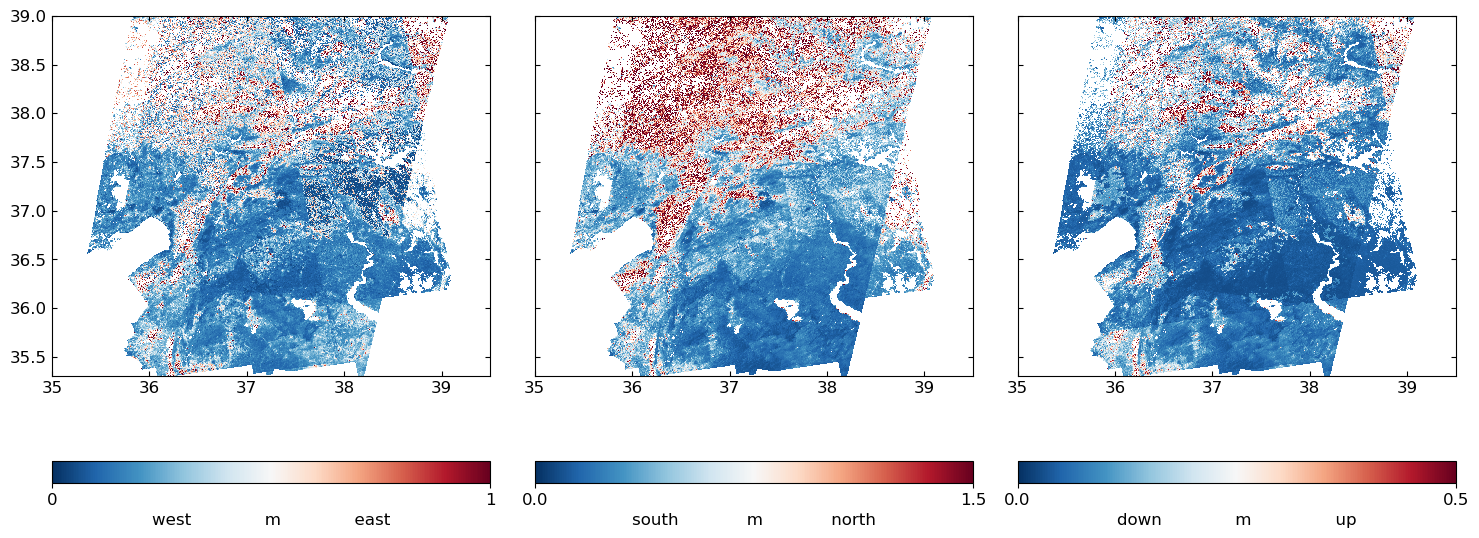

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharex=True, sharey=True)
kwargs = dict(extent=(W, E, S, N), cmap='RdBu_r', interpolation='nearest')
vlims = [1.0, 1.5, 0.5]
im1 = axs[0].imshow(dis_enu_std[0,:].reshape(length, width), vmin=0, vmax=vlims[0], **kwargs)
im2 = axs[1].imshow(dis_enu_std[1,:].reshape(length, width), vmin=0, vmax=vlims[1], **kwargs)
im3 = axs[2].imshow(dis_enu_std[2,:].reshape(length, width), vmin=0, vmax=vlims[2], **kwargs)
ims = [im1, im2, im3]
labels = ['west              m              east',
          'south             m             north',
          'down              m                up']
for i, (ax, im, label, vlim) in enumerate(zip(axs, ims, labels, vlims)):
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=[-vlim, 0, vlim])
    cbar.set_label(label)
fig.tight_layout()
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

# output
out_fig = os.path.join(proj_dir, f'notebooks/docs/dis_enu_std.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /Users/yunjunz/data/archives/2023TurkeyEQ/notebooks/docs/dis_enu_msk.png


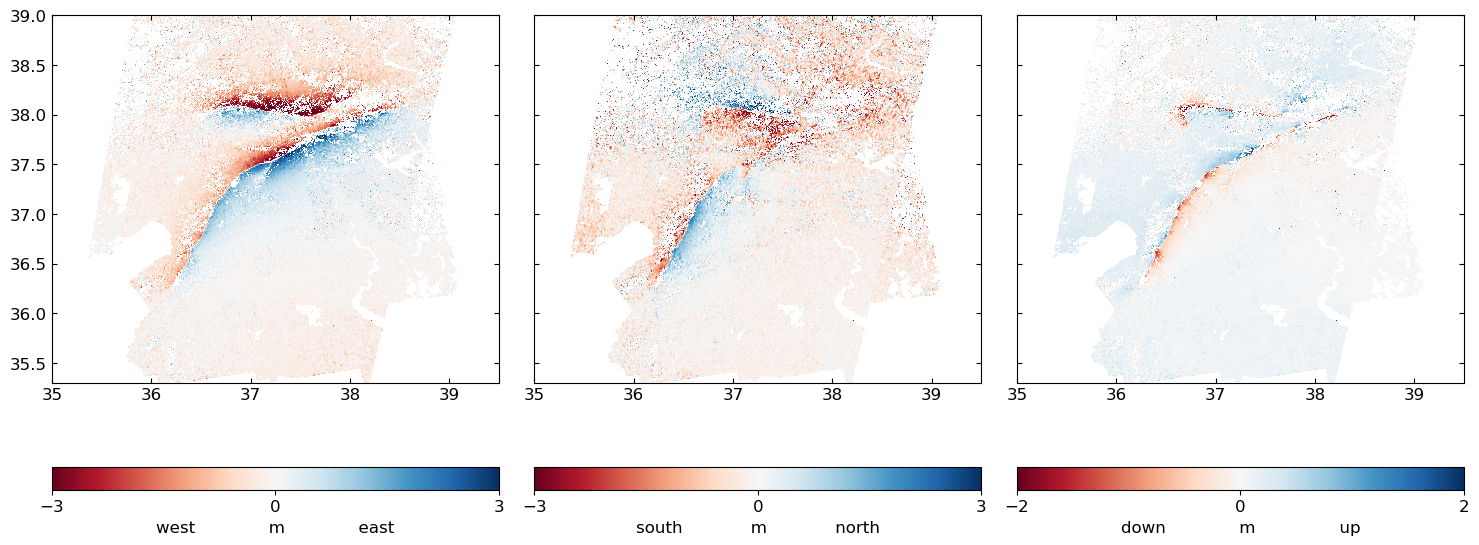

In [79]:
# mask
dis_enu_msk = np.array(dis_enu, dtype=np.float32)
max_std_list = [1.0, 1.5, 0.5]
for i, max_std in enumerate(max_std_list):
    dis_enu_msk[i][dis_enu_std[i] > max_std] = np.nan

# plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharex=True, sharey=True)
kwargs = dict(extent=(W, E, S, N), cmap='RdBu', interpolation='nearest')
vlims = [3, 3, 2]
im1 = axs[0].imshow(dis_enu_msk[0,:].reshape(length, width), vmin=-vlims[0], vmax=vlims[0], **kwargs)
im2 = axs[1].imshow(dis_enu_msk[1,:].reshape(length, width), vmin=-vlims[1], vmax=vlims[1], **kwargs)
im3 = axs[2].imshow(dis_enu_msk[2,:].reshape(length, width), vmin=-vlims[2], vmax=vlims[2], **kwargs)
ims = [im1, im2, im3]
labels = ['west              m              east',
          'south             m             north',
          'down              m                up']
for i, (ax, im, label, vlim) in enumerate(zip(axs, ims, labels, vlims)):
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=[-vlim, 0, vlim])
    cbar.set_label(label)
fig.tight_layout()
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

# output
out_fig = os.path.join(proj_dir, f'notebooks/docs/dis_enu_msk.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()